# `duckreg` for panel data: Applying Mundlak Regression to perform event studies at scale

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from duckreg.estimators import DuckMundlak, DuckMundlakEventStudy
import duckdb
import pyfixest as pf

np.random.seed(42)

In [2]:
def panel_dgp(
    num_units=1000,
    num_periods=30,
    num_treated=50,
    treatment_start=15,
    hetfx=False,
    base_treatment_effect=np.repeat(0, 15),
    ar_coef=0.2,  # Autoregressive coefficient for epsilon_it
    sigma_unit=1,
    sigma_time=0.5,
    sigma_epsilon=0.5,  # Standard deviation of epsilon_it
):
    unit_intercepts = np.random.normal(0, sigma_unit, num_units)

    # Generate day-of-the-week pattern
    day_effects = np.array(
        [-0.1, 0.1, 0, 0, 0.1, 0.5, 0.5]
    )  # Stronger effects on weekends
    day_pattern = np.tile(day_effects, num_periods // 7 + 1)[:num_periods]

    # Generate autoregressive structure in errors - IID won't work here
    ar_coef_time = 0.2
    ar_noise_time = np.random.normal(0, sigma_time, num_periods)
    time_intercepts = np.zeros(num_periods)
    time_intercepts[0] = ar_noise_time[0]
    for t in range(1, num_periods):
        time_intercepts[t] = ar_coef_time * time_intercepts[t - 1] + ar_noise_time[t]
    # Combine day-of-the-week pattern and autoregressive structure
    time_intercepts = day_pattern + time_intercepts - np.mean(time_intercepts)
    # Generate autoregressive noise for each unit
    ar_noise = np.random.normal(0, sigma_epsilon, (num_units, num_periods))
    noise = np.zeros((num_units, num_periods))
    noise[:, 0] = ar_noise[:, 0]
    for t in range(1, num_periods):
        noise[:, t] = ar_coef * noise[:, t - 1] + ar_noise[:, t]
    # N X T matrix of potential outcomes under control
    Y0 = unit_intercepts[:, np.newaxis] + time_intercepts[np.newaxis, :] + noise
    # Generate the base treatment effect (concave structure)
    # Generate heterogeneous multipliers for each unit
    if hetfx:
        heterogeneous_multipliers = np.random.uniform(0.5, 1.5, num_units)
    else:
        heterogeneous_multipliers = np.ones(num_units)

    # Create a 2D array to store the heterogeneous treatment effects
    treatment_effect = np.zeros((num_units, num_periods - treatment_start))
    for i in range(num_units):
        treatment_effect[i, :] = heterogeneous_multipliers[i] * base_treatment_effect

    # random assignment
    treated_units = np.random.choice(num_units, num_treated, replace=False)
    treatment_status = np.zeros((num_units, num_periods), dtype=bool)
    treatment_status[treated_units, treatment_start:] = True

    # Apply the heterogeneous treatment effect to the treated units
    Y1 = Y0.copy()
    for t in range(treatment_start, num_periods):
        Y1[:, t][treatment_status[:, t]] += treatment_effect[:, t - treatment_start][
            treatment_status[:, t]
        ]

    # Create a DataFrame
    unit_ids = np.repeat(np.arange(num_units), num_periods)
    time_ids = np.tile(np.arange(num_periods), num_units)
    W_it = treatment_status.flatten()
    Y_it = np.where(W_it, Y1.flatten(), Y0.flatten())
    df = pd.DataFrame(
        {
            "unit_id": unit_ids,
            "time_id": time_ids,
            "W_it": W_it.astype(int),
            "Y_it": Y_it,
        }
    )
    return df


# Function to create and populate DuckDB database
def create_duckdb_database(df, db_name="large_dataset.db", table="panel_data"):
    conn = duckdb.connect(db_name)
    conn.execute(f"DROP TABLE IF EXISTS {table}")
    conn.execute(f"CREATE TABLE {table} AS SELECT * FROM df")
    conn.close()
    print(f"Data loaded into DuckDB database: {db_name}")

Generate some data with 'sharkfin' temporal heterogeneity 

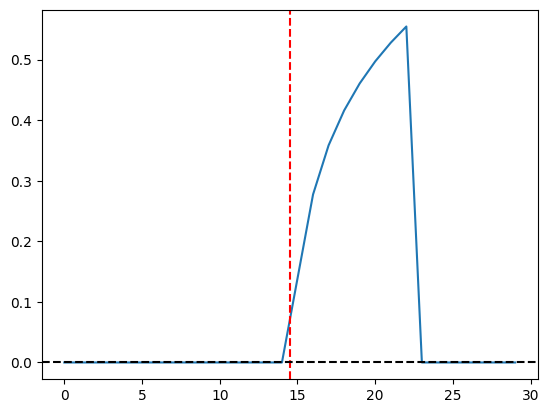

In [9]:
num_periods = 30
treat_start_period = 15
treat_effect_vector= 0.2 * np.log(2 * np.arange(1, num_periods - treat_start_period + 1))
treat_effect_vector[8:] = 0 # switch off effects after a week
sigma_i, sigma_t = 2, 1
event_study_true = np.r_[np.repeat(0, num_periods-treat_start_period), treat_effect_vector]
plt.plot(event_study_true)
plt.axvline(x=treat_start_period-.5, color='r', linestyle='--')
plt.axhline(y=0, color='k', linestyle='--')

In [22]:
df = panel_dgp(
    num_units=500_000, num_treated= 250_000,
    num_periods=30,
    treatment_start = treat_start_period,
    hetfx=False,
    base_treatment_effect = treat_effect_vector,
    sigma_unit = sigma_i, sigma_time = sigma_t,
)
print(df.shape)

db_name = 'event_study_data.db'
create_duckdb_database(df, db_name)

(15000000, 4)
Data loaded into DuckDB database: event_study_data.db


The full $N \times T$ dataset is very large.

## Static Specification

### Two-way Mundlak

In [5]:
mundlak = DuckMundlak(
    db_name="event_study_data.db",
    table_name="panel_data",
    outcome_var="Y_it",
    covariates=["W_it"],
    unit_col="unit_id",
    time_col="time_id",
    cluster_col="unit_id",
    n_bootstraps=100,
    seed = 42
)
mundlak.fit()

mundlak_results = mundlak.summary()

restab = pd.DataFrame(
    np.c_[mundlak_results["point_estimate"], mundlak_results["standard_error"]],
    columns=["point_estimate", "standard_error"],
).iloc[1, :]
restab

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


point_estimate    0.215242
standard_error    0.000443
Name: 1, dtype: float64

In [6]:
treat_effect_vector.mean()

0.21533040462966416

The Two-way Mundlak specification consistently recovers the average treatment effect in the post-treatment period. Under staggered adoption, however, this guarantee is lost, which has produced a cambrian explosion of work in applied econometrics. For our purposes, we will assume we have enough data to estimate the specification for each treatment cohort separately; combining the effects after the fact will simply use cohort sizes (Sun and Abraham 2020).

## Dynamic Specification

### Single Treatment Cohort

In-memory implementation in `pyfixest`.

In [10]:
%%time
df["ever_treated"] = df.groupby("unit_id")["W_it"].transform("max")
m2 = pf.feols("""
              Y_it ~ i(time_id, ever_treated,  ref = 14) |
                unit_id + time_id
              """,
              df
             )
evstudy_coefs = m2.coef().values
# insert zero in reference period
evstudy_coefs = np.insert(evstudy_coefs, 14, 0)

CPU times: user 39 s, sys: 10.6 s, total: 49.6 s
Wall time: 18.2 s


### compressed estimation

We use the dynamic specification which incorporates a cohort intercept, time dummies, and time X treated dummies and compress to this level.

In [11]:
conn = duckdb.connect("event_study_data.db")
print(conn.execute("SELECT * FROM panel_data LIMIT 5").fetchdf())
conn.close()

   unit_id  time_id  W_it      Y_it
0        0        0     0 -1.154075
1        0        1     0 -0.742778
2        0        2     0  1.434129
3        0        3     0  1.462963
4        0        4     0  1.771794


In [14]:
mundlak = DuckMundlakEventStudy(
    db_name="event_study_data.db",
    table_name="panel_data",
    outcome_var="Y_it",
    treatment_col="W_it",
    unit_col="unit_id",
    time_col="time_id",
    cluster_col="unit_id",
    n_bootstraps=0, # set to nonzero to get block-bootstrapped standard errors
    seed=42,
)

mundlak.fit()
evsum = mundlak.summary()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [23]:
print(f"{mundlak.df_compressed.shape[0]} is considerably smaller than {df.shape[0]}")

90 is considerably smaller than 15000000


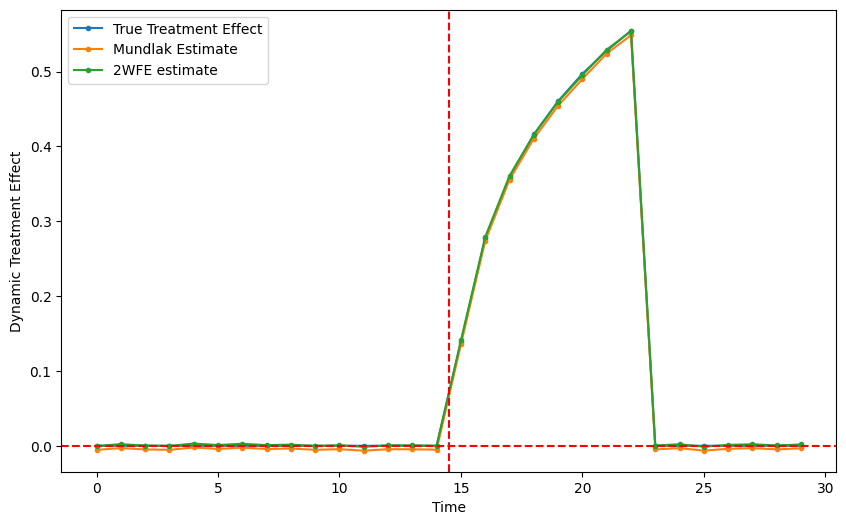

In [15]:
mundlak_estimates = evsum["point_estimate"]["15"]
time_labels = [
    int(x.replace("treatment_time_15_", "")) for x in mundlak_estimates.index
]
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(event_study_true, marker=".", label="True Treatment Effect")
ax.plot(time_labels, mundlak_estimates, marker=".", label="Mundlak Estimate")
ax.plot(time_labels, evstudy_coefs, marker=".", label="2WFE estimate")
ax.axvline(14.5, color="red", linestyle="--")
ax.axhline(0, color="red", linestyle="--")
ax.set_ylabel("Dynamic Treatment Effect")
ax.set_xlabel("Time")
ax.legend()
plt.show()

The two-way Mundlak specification correctly recovers the treatment effect/impulse response function.

### Multiple cohorts

Event study, followed by fully interacted (Sunab / Wooldridge) regression.

In [16]:
def panel_dgp_stagg(
    num_units=100,
    num_periods=30,
    num_treated=[50],
    treatment_start_cohorts=[15],
    sigma_unit=1,
    sigma_time=0.5,
    sigma_epsilon=0.2,
    hetfx=False,
    base_treatment_effects=[0.1 * np.log(np.arange(1, 30 - 15 + 1))],
    return_dataframe=True,
    ar_coef=0.8,
):
    # unit FEs
    unit_intercepts = np.random.normal(0, sigma_unit, num_units)
    ####################################################################
    # time FEs: Generate day-of-the-week pattern
    day_effects = np.array(
        [-0.1, 0.1, 0, 0, 0.1, 0.5, 0.5]
    )  # Stronger effects on weekends
    day_pattern = np.tile(day_effects, num_periods // 7 + 1)[:num_periods]
    # autoregressive structure in time FEs
    ar_coef_time = 0.2
    ar_noise_time = np.random.normal(0, sigma_time, num_periods)
    time_intercepts = np.zeros(num_periods)
    time_intercepts[0] = ar_noise_time[0]
    for t in range(1, num_periods):
        time_intercepts[t] = ar_coef_time * time_intercepts[t - 1] + ar_noise_time[t]
    # Combine day-of-the-week pattern and autoregressive structure
    time_intercepts = day_pattern + time_intercepts - np.mean(time_intercepts)
    ####################################################################
    # Generate autoregressive noise for each unit
    ar_noise = np.random.normal(0, sigma_epsilon, (num_units, num_periods))
    noise = np.zeros((num_units, num_periods))
    noise[:, 0] = ar_noise[:, 0]
    for t in range(1, num_periods):
        noise[:, t] = ar_coef * noise[:, t - 1] + ar_noise[:, t]
    # N X T matrix of potential outcomes under control
    Y0 = unit_intercepts[:, np.newaxis] + time_intercepts[np.newaxis, :] + noise
    ####################################################################
    # Generate heterogeneous multipliers for each unit
    if hetfx:
        heterogeneous_multipliers = np.random.uniform(0.5, 1.5, num_units)
    else:
        heterogeneous_multipliers = np.ones(num_units)
    # random assignment
    treated_units = np.array([], dtype=int)
    treatment_status = np.zeros((num_units, num_periods), dtype=bool)
    ####################################################################
    # Create a 2D array to store the heterogeneous treatment effects
    treatment_effect = np.zeros((num_units, num_periods))
    # iterate over treatment cohorts
    for cohort_idx, (treatment_start, num_treated_cohort) in enumerate(
        zip(treatment_start_cohorts, num_treated)
    ):
        base_treatment_effect = base_treatment_effects[cohort_idx]
        cohort_treatment_effect = np.zeros((num_units, num_periods - treatment_start))

        for i in range(num_units):
            cohort_treatment_effect[i, :] = (
                heterogeneous_multipliers[i] * base_treatment_effect
            )
        cohort_treated_units = np.random.choice(
            np.setdiff1d(np.arange(num_units), treated_units),
            num_treated_cohort,
            replace=False,
        )
        treated_units = np.concatenate((treated_units, cohort_treated_units))
        treatment_status[cohort_treated_units, treatment_start:] = True
        treatment_effect[
            cohort_treated_units, treatment_start:
        ] += cohort_treatment_effect[cohort_treated_units, :]

    # Apply the heterogeneous treatment effect to the treated units
    Y1 = Y0.copy()
    Y1[treatment_status] += treatment_effect[treatment_status]
    ####################################################################
    result = {
        "Y1": Y1,
        "Y0": Y0,
        "W": treatment_status,
        "unit_intercepts": unit_intercepts,
        "time_intercepts": time_intercepts,
    }

    if return_dataframe:
        # Create a DataFrame
        unit_ids = np.repeat(np.arange(num_units), num_periods)
        time_ids = np.tile(np.arange(num_periods), num_units)
        W_it = treatment_status.flatten().astype(int)
        Y_it = np.where(W_it, Y1.flatten(), Y0.flatten())
        unit_intercepts_flat = np.repeat(unit_intercepts, num_periods)
        time_intercepts_flat = np.tile(time_intercepts, num_units)
        df = pd.DataFrame(
            {
                "unit_id": unit_ids,
                "time_id": time_ids,
                "W_it": W_it,
                "Y_it": Y_it,
                "unit_intercept": unit_intercepts_flat,
                "time_intercept": time_intercepts_flat,
            }
        )
        result["dataframe"] = df
    return result

Effect functions:
+ Cohort 1: mean reversal: big bump that decays to zero within 10 days, then zero
+ Cohort 2: shark-fin - logarithmic for the first week, then 0
+ Cohort 3: sinusoidal 

In [17]:
num_periods = 30
treatment_start_cohorts = [10, 15, 20]
num_treated_units = [25_000, 50_000, 25_000]

# effect functions
treat_effect_vector_1 = np.log(2 * np.arange(1, num_periods - treatment_start_cohorts[1]+ 1))
treat_effect_vector_1[8:] = 0  # switch off effects after a week
base_treatment_effects = [
    np.r_[np.linspace(2, 0, num_periods - treatment_start_cohorts[0] - 10), np.repeat(0, 10)],
    treat_effect_vector_1,
    np.sin(np.arange(1, num_periods - treatment_start_cohorts[2] + 1))  # Treatment effect function for cohort 2
]

sigma_i, sigma_t = 2, 1
sigma_epsilon=1
dgp = panel_dgp_stagg(
    num_units=100_000, num_treated=num_treated_units,
    num_periods=num_periods,
    treatment_start_cohorts = treatment_start_cohorts, hetfx=False,
    base_treatment_effects= base_treatment_effects,
    sigma_unit = sigma_i, sigma_time = sigma_t,
    sigma_epsilon=sigma_epsilon,
)
Y0, Y1, W, df = dgp["Y0"], dgp["Y1"], dgp["W"], dgp["dataframe"]

In [18]:
db_name = 'stagg_event_study_data.db'
create_duckdb_database(df, db_name)

Data loaded into DuckDB database: stagg_event_study_data.db


In [19]:
mundlak = DuckMundlakEventStudy(
    db_name="stagg_event_study_data.db",
    table_name="panel_data",
    outcome_var="Y_it",
    treatment_col="W_it",
    unit_col="unit_id",
    time_col="time_id",
    cluster_col="unit_id",
    n_bootstraps=0,
    seed=42,
)

mundlak.fit()
evsum = mundlak.summary()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

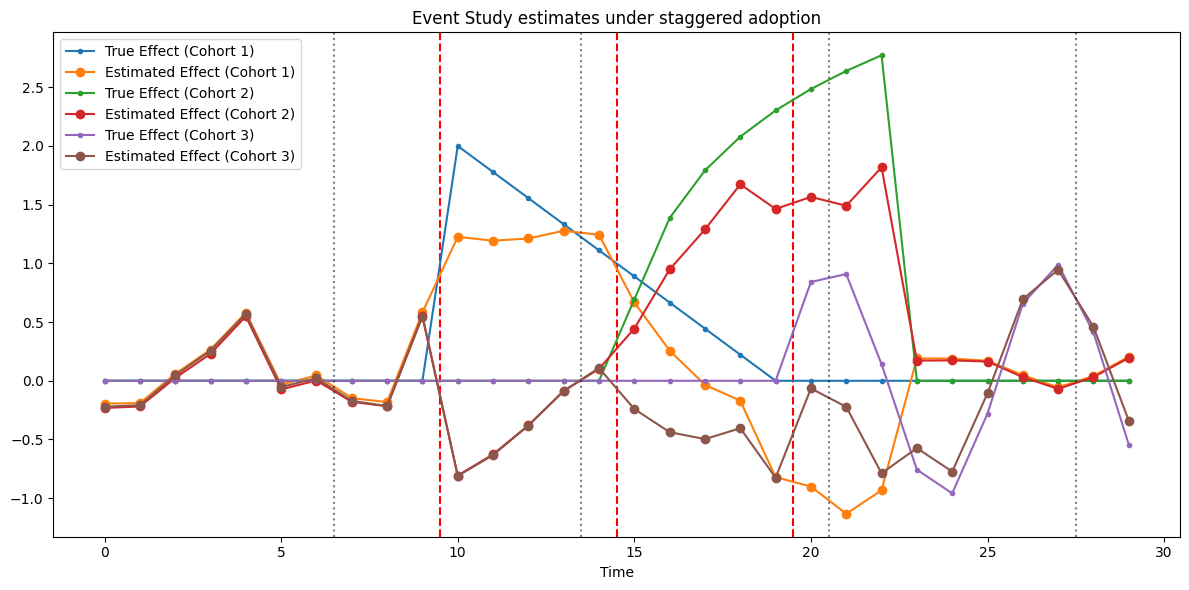

In [20]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

for cohort_start in treatment_start_cohorts:
    ax.axvline(x=cohort_start - 0.5, color='red', linestyle='--')
# Plot the true treatment effect functions for each cohort
for cohort_idx, cohort_start in enumerate(treatment_start_cohorts):
    effect_vector = base_treatment_effects[cohort_idx]
    effect_vector_padded = np.zeros(num_periods)
    effect_vector_padded[cohort_start:cohort_start+len(effect_vector)] = effect_vector
    ax.plot(effect_vector_padded, marker=".", label=f"True Effect (Cohort {cohort_idx + 1})")
    # estimated cohort effect
    cohort_estimates = evsum["point_estimate"][f"{cohort_start}"].values
    ax.plot(cohort_estimates, marker="o", label=f"Estimated Effect (Cohort {cohort_idx + 1})")

# Overlay week dotted lines
for week in range(1, num_periods // 7 + 1):
    ax.axvline(x=week * 7 - 0.5, color='k', linestyle=':', alpha=0.5)

# Add labels and title
ax.set_xlabel("Time")
ax.set_title("Event Study estimates under staggered adoption")
# Add legend
ax.legend()
# Show the plot
plt.tight_layout()
plt.show()

Again, we get the correct treatment effect/impulse response function for each cohort. Estimates are considerably noisier, however.